# Preparation for analysis

In [56]:
from sklearn.model_selection import train_test_split
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:

df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/feb/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')

def parse_distribution(dist_str):

    dist_list = ast.literal_eval(dist_str)  
    return dict(dist_list)

df['parsed_11'] = df['roberta-large-predictions'].apply(parse_distribution)
df['parsed_6'] = df['mapped_predictions'].apply(parse_distribution)


In [52]:
df_11 = pd.json_normalize(df['parsed_11'])
df_6  = pd.json_normalize(df['parsed_6'])


df_11.columns = [f"em_11_{col}" for col in df_11.columns] 
df_6.columns = [f"em_6_{col}" for col in df_6.columns]

df = pd.concat([df, df_11, df_6], axis=1)

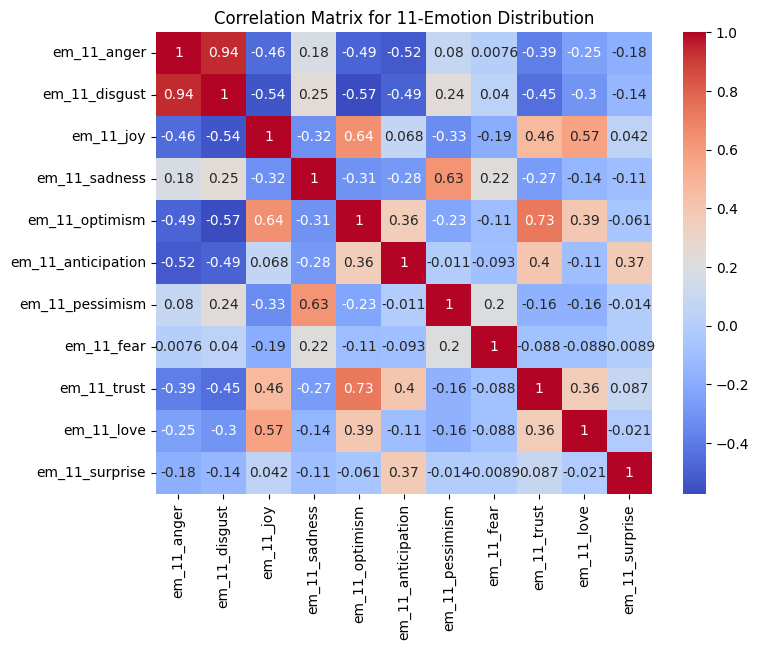

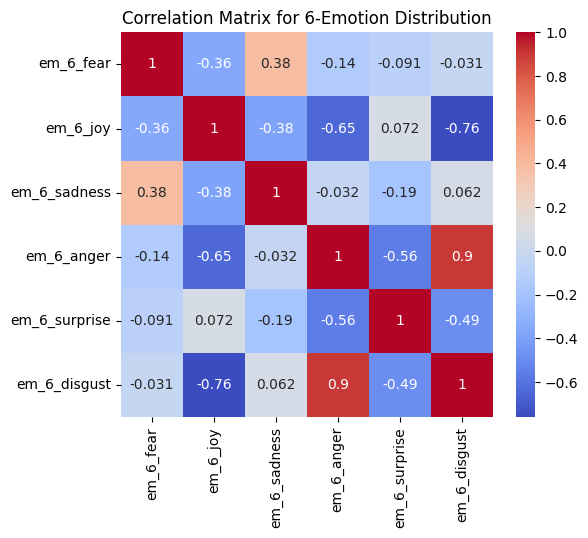

In [53]:
corr_11 = df[[col for col in df.columns if col.startswith("em_11_")]].corr()
corr_6 = df[[col for col in df.columns if col.startswith("em_6_")]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_11, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for 11-Emotion Distribution")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(corr_6, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for 6-Emotion Distribution")
plt.show()

In [73]:
replies_df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/aug/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')
tweets_df = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/aug/averaged_predictions.csv")

def parse_distribution(dist_str):
    return dict(ast.literal_eval(dist_str))

replies_df['label_distribution'] = replies_df['mapped_predictions'].apply(parse_distribution)
tweets_df['tweet_distribution'] = tweets_df['mapped_predictions'].apply(parse_distribution)
tweets_df['average_reply_distribution'] = tweets_df['averaged_predictions'].apply(parse_distribution)
tweets_df['clip_distribution'] = tweets_df['clip_predictions'].apply(parse_distribution)

In [74]:
def average_distributions(row):
    dist_1 = row['tweet_distribution']
    dist_2 = row['clip_distribution']
    avg_dist = {key: (dist_1[key] + dist_2[key]) / 2 for key in dist_1}
    return avg_dist
tweets_df['clip_tweet_dist'] = tweets_df.apply(average_distributions, axis=1)

In [75]:
from scipy.spatial.distance import jensenshannon

categories = ['anger', 'surprise', 'disgust', 'sadness', 'fear', 'joy']

def compute_jsd(tweet_dist, reply_dist):
    tweet_probs = [tweet_dist[cat] for cat in categories]
    reply_probs = [reply_dist[cat] for cat in categories]

    return jensenshannon(tweet_probs, reply_probs, base=2)


In [76]:
tweets_df['jsd'] = tweets_df.apply(lambda row: compute_jsd(row['tweet_distribution'], row['average_reply_distribution']), axis=1)
tweets_df['jsd_image'] = tweets_df.apply(lambda row: compute_jsd(row['tweet_distribution'], row['clip_distribution']), axis=1)
tweets_df['jsd_multi'] = tweets_df.apply(lambda row: compute_jsd(row['clip_tweet_dist'], row['average_reply_distribution']), axis=1)

In [77]:
tweets_df['jsd_image_reply'] = tweets_df.apply(lambda row: compute_jsd(row['clip_distribution'], row['average_reply_distribution']), axis=1)

In [78]:
from scipy.stats import entropy

def compute_entropy(dist):
    probs = list(dist.values())
    return entropy(probs, base=2)

tweets_df['tweet_entropy'] = tweets_df['tweet_distribution'].apply(compute_entropy)
tweets_df['reply_entropy'] = tweets_df['average_reply_distribution'].apply(compute_entropy)
tweets_df['multi_entropy'] = tweets_df['clip_tweet_dist'].apply(compute_entropy)


In [79]:
grouped_replies = replies_df.groupby('conversation_id')


In [80]:
from itertools import combinations
import numpy as np

def pairwise_jsd(distributions):
    # Compute all pairwise JSD between distributions
    jsd_values = []
    for dist1, dist2 in combinations(distributions, 2):
        jsd = jensenshannon(list(dist1.values()), list(dist2.values()), base=2)
        jsd_values.append(jsd)
    return jsd_values

# Calculate pairwise JSD for replies of each tweet
reply_divergence = {}

for tweet_id, group in grouped_replies:
    reply_distributions = group['label_distribution'].tolist()
    jsd_values = pairwise_jsd(reply_distributions)
    reply_divergence[tweet_id] = {
        "mean_jsd": np.mean(jsd_values) if jsd_values else 0,
        "max_jsd": max(jsd_values) if jsd_values else 0,
        "pairwise_jsd": jsd_values
    }

# Convert to DataFrame for easier analysis
divergence_df = pd.DataFrame.from_dict(reply_divergence, orient='index')
divergence_df.reset_index(inplace=True)
divergence_df.rename(columns={"index": "conversation_id"}, inplace=True)


In [81]:
from scipy.spatial.distance import cosine

def calculate_cosine_similarity(row):
    dist_1 = row['average_reply_distribution']
    dist_2 = row['clip_tweet_dist']
    
    keys = sorted(dist_1.keys())
    vector_1 = [dist_1[key] for key in keys]
    vector_2 = [dist_2[key] for key in keys]
    
    return 1 - cosine(vector_1, vector_2)

tweets_df['cosine_similarity_multi'] = tweets_df.apply(calculate_cosine_similarity, axis=1)

In [82]:
tweets_df.head()

conversation_id                                         tweet_text  \
0  1156745986548670465  Quote of the night? Gillibrand gets laughs say...   
1  1156756706296238081  Is climate change a massive hoax or not?  Whic...   
2  1156782989344251904  Hottest month ever: June 2019 was recorded as ...   
3  1156786644906840064  ICYMI: Trump Slaps #Tariffs on Solar Panels in...   
4  1156793069435572225  When i was young i used to see butterflies eve...   

                           roberta-large-predictions  \
0  [('anticipation', 0.6186065077781677), ('fear'...   
1  [('anticipation', 0.679983913898468), ('surpri...   
2  [('fear', 0.706391453742981), ('anger', 0.2220...   
3  [('anger', 0.8689755201339722), ('disgust', 0....   
4  [('sadness', 0.9452576041221619), ('fear', 0.8...   

                                averaged_predictions  \
0  [('anger', 0.16990943452855908), ('fear', 0.05...   
1  [('anger', 0.2943476886939764), ('fear', 0.109...   
2  [('anger', 0.025321945604377914), ('fear', 0.1...   
3  [('anger', 0.008867843414662797), ('fear', 0.0...   
4  [('anger', 0.01091247527479495), ('fear', 0.12...   

                                  mapped_predictions  \
0  [('anger', 0.012048927230430958), ('fear', 0.2...   
1  [('anger', 0.03949322766488157), ('fear', 0.09...   
2  [('anger', 0.11455001581186203), ('fear', 0.38...   
3  [('anger', 0.4027862404695535), ('fear', 0.023...   
4  [('anger', 0.011271691272930396), ('fear', 0.4...   

   cosine_similarity_tweet_replies  \
0                         0.809521   
1                         0.238486   
2                         0.650414   
3                         0.082587   
4                         0.700972   

                                    clip_predictions  \
0  [('disgust', 0.30397248), ('fear', 0.25486195)...   
1  [('anger', 0.28693756), ('fear', 0.18922445), ...   
2  [('fear', 0.81379455), ('surprise', 0.05587873...   
3  [('anger', 0.5647884), ('fear', 0.17118351), (...   
4  [('fear', 0.41976), ('sadness', 0.22444683), (...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.771768                      0.647942   
1                        0.748564                      0.529061   
2                        0.303197                      0.860183   
3                        0.183566                      0.784000   
4                        0.589017                      0.921277   

  similarity_bin  ...                                  clip_distribution  \
0        0.6-0.8  ...  {'disgust': 0.30397248, 'fear': 0.25486195, 'a...   
1        0.4-0.6  ...  {'anger': 0.28693756, 'fear': 0.18922445, 'sur...   
2        0.8-1.0  ...  {'fear': 0.81379455, 'surprise': 0.055878732, ...   
3        0.6-0.8  ...  {'anger': 0.5647884, 'fear': 0.17118351, 'disg...   
4        0.8-1.0  ...  {'fear': 0.41976, 'sadness': 0.22444683, 'ange...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'anger': 0.11670482861521549, 'fear': 0.25480...  0.394924  0.489083   
1  {'anger': 0.16321539383244077, 'fear': 0.14451...  0.700589  0.503822   
2  {'anger': 0.07178915290593102, 'fear': 0.59777...  0.414283  0.383030   
3  {'anger': 0.4837873202347768, 'fear': 0.097175...  0.821631  0.416908   
4  {'anger': 0.0933283306364652, 'fear': 0.428222...  0.405718  0.297059   

  jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0  0.270344         0.377186       2.015008       2.423982       2.348826   
1  0.545506         0.449958       1.764798       1.999899       2.368556   
2  0.520306         0.656855       2.371642       1.968250       1.890609   
3  0.753946         0.719171       1.864199       1.318870       2.067231   
4  0.452829         0.519963       1.836066       2.108649       2.067818   

   cosine_similarity_multi  
0                 0.871561  
1                 0.506343  
2                 0.445610  
3                 0.142484  
4                 0.661336  

[5 rows x 23

In [83]:
divergence_df.to_csv("/work/ptyagi/masterthesis/data/predictions/aug/divergence.csv", index=False)
tweets_df.to_csv("/work/ptyagi/masterthesis/data/predictions/aug/analysis_metrics.csv", index=False)

# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/feb/analysis_metrics.csv")
replies_df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/feb/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')
divergence_df = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/feb/divergence.csv")
annotated = pd.read_csv("/work/ptyagi/masterthesis/data/tmp/annotations_and_predictions.csv")

In [3]:
data['clip_distribution'] = data['clip_distribution'].apply(ast.literal_eval)
data['average_reply_distribution'] = data['average_reply_distribution'].apply(ast.literal_eval)
data['tweet_distribution'] = data['tweet_distribution'].apply(ast.literal_eval)
data['clip_tweet_dist'] = data['clip_tweet_dist'].apply(ast.literal_eval)

In [4]:
data['average_reply_distribution'] = data['average_reply_distribution'].apply(lambda d: {k: round(v, 7) for k, v in d.items()})
data['tweet_distribution'] = data['tweet_distribution'].apply(lambda d: {k: round(v, 8) for k, v in d.items()})
data['clip_tweet_dist'] = data['clip_tweet_dist'].apply(lambda d: {k: round(v, 7) for k, v in d.items()})

In [5]:
merged = pd.merge(data[['conversation_id', 'tweet_text','matched_filename', 'tweet_distribution', 'average_reply_distribution',
'clip_distribution', 'clip_tweet_dist', 'jsd', 'jsd_image', 'jsd_multi','jsd_image_reply','cosine_similarity_multi']], 
annotated[['manual_label', 'conversation_id', 'replies']], on='conversation_id', how='inner')

In [6]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy.stats import entropy

def top_k_accuracy(predictions, true_labels, k):
    correct = 0
    for dist, true_label in zip(predictions, true_labels):
        # Align the distribution to the fixed order
        ordered_dist = [dist[cat] for cat in categories]
        top_k_indices = np.argsort(ordered_dist)[-k:][::-1]  # Indices of the top-k probabilities
        top_k_labels = [categories[i] for i in top_k_indices]
        if true_label in top_k_labels:
            correct += 1
    return correct / len(true_labels)

def evaluate_predictions(predicted_distributions, manual_labels, categories):

    predicted_labels = []
    for dist in predicted_distributions:
        ordered_dist = [dist[cat] for cat in categories]
        predicted_label = categories[np.argmax(ordered_dist)]
        predicted_labels.append(predicted_label)

    accuracy = accuracy_score(manual_labels, predicted_labels)
    precision = precision_score(manual_labels, predicted_labels, labels=categories, average='weighted')
    recall = recall_score(manual_labels, predicted_labels, labels=categories, average='weighted')

    cross_entropy_losses = []
    for dist, true_label in zip(predicted_distributions, manual_labels):
        true_one_hot = np.zeros(len(categories))
        true_one_hot[categories.index(true_label)] = 1
        predicted_probs = [dist[cat] for cat in categories]
        cross_entropy_loss = entropy(true_one_hot, predicted_probs)
        cross_entropy_losses.append(cross_entropy_loss)

    average_cross_entropy_loss = np.mean(cross_entropy_losses)

    top_2_accuracy = top_k_accuracy(predicted_distributions, manual_labels, k=2)
    top_3_accuracy = top_k_accuracy(predicted_distributions, manual_labels, k=3)
    
    print("Predicted Labels:", predicted_labels)
    print("Manual labels:", manual_labels)
    print("Accuracy:", accuracy)
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall)
    print("Average Cross-Entropy Loss:", average_cross_entropy_loss)
    print("Top-2 Accuracy:", top_2_accuracy)
    print("Top-3 Accuracy:", top_3_accuracy)

    return {
        "predicted_labels": predicted_labels,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "average_cross_entropy_loss": average_cross_entropy_loss,
        "Top-2 Accuracy": top_2_accuracy,
        "Top-3 Accuracy": top_3_accuracy
    }
categories = ['anger', 'surprise', 'disgust', 'sadness', 'fear', 'joy']
manual_labels = merged["manual_label"].to_list()

In [7]:
predicted_distributions = merged["tweet_distribution"].to_list() 
results = evaluate_predictions(predicted_distributions, manual_labels, categories)

Predicted Labels: ['anger', 'joy', 'joy', 'joy', 'joy', 'disgust', 'disgust', 'joy', 'disgust', 'joy', 'joy', 'surprise', 'disgust', 'joy', 'joy', 'joy', 'joy', 'joy', 'anger', 'anger', 'anger', 'joy', 'anger', 'anger', 'fear', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'disgust', 'disgust', 'sadness', 'fear', 'fear', 'fear', 'fear', 'fear', 'joy', 'joy', 'fear', 'joy', 'joy', 'joy', 'sadness', 'disgust', 'joy', 'anger', 'joy', 'fear', 'fear', 'disgust', 'joy', 'joy', 'joy', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'fear', 'surprise', 'surprise', 'anger', 'disgust', 'joy', 'joy', 'surprise', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'joy', 'joy', 'joy', 'disgust', 'surprise', 'surprise', 'surprise', 'joy', 'surprise', 'joy', 'joy', 'anger', 'anger', 'fear', 'disgust']
Manual labels: ['joy', 'sadness', 'sadness', 'anger', 'sadness', 'disgust', 'anger', 'joy', 'disgust', 'joy', 'anger', 'disgust', 'anger'

In [8]:
predicted_distributions = merged["clip_distribution"].to_list() 
results = evaluate_predictions(predicted_distributions, manual_labels, categories)

Predicted Labels: ['sadness', 'anger', 'anger', 'disgust', 'anger', 'anger', 'anger', 'anger', 'fear', 'disgust', 'fear', 'fear', 'anger', 'anger', 'surprise', 'fear', 'fear', 'fear', 'anger', 'anger', 'anger', 'anger', 'fear', 'fear', 'anger', 'anger', 'anger', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'anger', 'anger', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'fear', 'disgust', 'disgust', 'anger', 'fear', 'anger', 'joy', 'anger', 'anger', 'disgust', 'anger', 'disgust', 'disgust', 'anger', 'anger', 'anger', 'disgust', 'anger', 'anger', 'anger', 'anger', 'anger', 'joy', 'fear', 'anger', 'anger', 'anger', 'fear', 'fear', 'surprise', 'anger', 'anger', 'anger', 'anger', 'anger', 'anger', 'anger', 'fear', 'anger', 'anger', 'anger', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'anger', 'fear', 'fear', 'disgust', 'disgust']
Manual labels: ['joy', 'sadness', 'sadness', 'anger', 'sadness', 'disgust', 'anger', 'joy

In [9]:
predicted_distributions = merged["clip_tweet_dist"].to_list() 
results = evaluate_predictions(predicted_distributions, manual_labels, categories)

Predicted Labels: ['anger', 'anger', 'joy', 'joy', 'joy', 'anger', 'anger', 'joy', 'fear', 'joy', 'joy', 'surprise', 'anger', 'joy', 'joy', 'joy', 'joy', 'joy', 'anger', 'anger', 'anger', 'joy', 'anger', 'anger', 'fear', 'joy', 'joy', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'disgust', 'surprise', 'fear', 'fear', 'fear', 'fear', 'fear', 'joy', 'joy', 'disgust', 'joy', 'joy', 'anger', 'joy', 'anger', 'joy', 'disgust', 'joy', 'fear', 'fear', 'anger', 'joy', 'anger', 'joy', 'anger', 'anger', 'anger', 'anger', 'anger', 'fear', 'fear', 'surprise', 'anger', 'anger', 'joy', 'joy', 'surprise', 'anger', 'anger', 'anger', 'anger', 'anger', 'anger', 'anger', 'joy', 'joy', 'joy', 'anger', 'surprise', 'surprise', 'surprise', 'fear', 'fear', 'joy', 'joy', 'anger', 'anger', 'disgust', 'disgust']
Manual labels: ['joy', 'sadness', 'sadness', 'anger', 'sadness', 'disgust', 'anger', 'joy', 'disgust', 'joy', 'anger', 'disgust', 'anger', 'surp

/home/ptyagi/miniconda3/envs/thesis_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, tweets_df = train_test_split(temp_data, test_size=1/3, random_state=42)

In [11]:
tweets_df.head(3)

conversation_id                                         tweet_text  \
198  1096448460583260161  Our students took the lead in the fight agains...   
332  1096541711847833601  Why are Arctic fisheries under threat due to c...   
43   1095943507779305472  Everywhere there are signs that we have reache...   

                             roberta-large-predictions  \
198  [('optimism', 0.9810001850128174), ('joy', 0.8...   
332  [('fear', 0.9263613820075989), ('sadness', 0.4...   
43   [('fear', 0.871435284614563), ('sadness', 0.61...   

                                    mapped_predictions  \
198  [('fear', 0.011164323351160214), ('disgust', 0...   
332  [('fear', 0.48925698009041596), ('disgust', 0....   
43   [('fear', 0.49675462303614526), ('disgust', 0....   

                                  averaged_predictions  \
198  [('fear', 0.06047392221213688), ('disgust', 0....   
332  [('fear', 0.08450050080627194), ('disgust', 0....   
43   [('fear', 0.0318985875978461), ('disgust', 0.0...   

     cosine_similarity_tweet_replies  \
198                         0.339843   
332                         0.542696   
43                          0.269678   

                                      clip_predictions  \
198  [('anger', 0.5489631), ('disgust', 0.13539463)...   
332  [('anger', 0.31692), ('sadness', 0.2740194), (...   
43   [('surprise', 0.3934697), ('disgust', 0.300639...   

     cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
198                        0.736023                      0.115306   
332                        0.494711                      0.629708   
43                         0.662813                      0.344603   

                          matched_filename  ...  \
198  id_1096448460583260161_2019-02-15.jpg  ...   
332  id_1096541711847833601_2019-02-15.jpg  ...   
43   id_1095943507779305472_2019-02-14.jpg  ...   

                                     clip_distribution  \
198  {'anger': 0.5489631, 'disgust': 0.13539463, 'f...   
332  {'anger': 0.31692, 'sadness': 0.2740194, 'fear...   
43   {'surprise': 0.3934697, 'disgust': 0.3006397, ...   

                                       clip_tweet_dist       jsd jsd_image  \
198  {'fear': 0.0544754, 'disgust': 0.0693323, 'joy...  0.697371  0.817883   
332  {'fear': 0.3267564, 'disgust': 0.0768788, 'joy...  0.440004  0.433171   
43   {'fear': 0.2610501, 'disgust': 0.1971596, 'joy...  0.654559  0.604619   

     jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
198   0.384342         0.332901       0.894837       2.411120       2.119343   
332   0.431538         0.481270       2.008410       2.096574       2.366826   
43    0.526427         0.486785       1.990189       1.887569       2.389172   

     cosine_similarity_multi  
198                 0.668684  
332                 0.576442  
43                  0.559702  

[3 rows x 22 columns]

In [12]:
divergence_df.head()

conversation_id  mean_jsd  max_jsd pairwise_jsd
0  1091717129995542528       0.0      0.0           []
1  1092776506106015746       0.0      0.0           []
2  1092784983998189568       0.0      0.0           []
3  1093132427810271233       0.0      0.0           []
4  1094070997135822848       0.0      0.0           []

In [13]:
def visualize_tweets(data, start_idx, end_idx, rows=2, cols=4):
    """
    Visualizes tweets and images for a specified index range.
    
    Parameters:
        data: DataFrame containing tweet information
        start_idx: Starting index of the range
        end_idx: Ending index of the range (exclusive)
        rows: Number of rows in the plot grid
        cols: Number of columns in the plot grid
    """
    batch_data = data.iloc[start_idx:end_idx]

    if batch_data.empty:
        print("No tweets found in the specified index range.")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easy indexing

    categories = ['fear', 'disgust', 'joy', 'surprise', 'sadness', 'anger']
    
    for i, (index, row) in enumerate(batch_data.iterrows()):
        print(row['conversation_id']) 
        # Get tweet details
        tweet_text = row["tweet_text"]
        tweet_distribution = row["tweet_distribution"]
        clip_distribution = row["clip_distribution"]
        ordered_dict = {key: clip_distribution[key] for key in categories}
        avg_dist = row["average_reply_distribution"]
        image_path = f'/work/ptyagi/ClimateVisions/Images/2019/02_February/{row["matched_filename"]}'

        try:
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f"Tweet ID: {row['conversation_id']}", fontsize=8)
        except FileNotFoundError:
            print(f"Image not found for conversation_id: {row['conversation_id']}")
            axes[i].axis('off')
            axes[i].set_title("Image Not Found", fontsize=8)

        # Print details in console for analysis
        print(f"Tweet {i + 1}: {tweet_text}")
        print(f"Tweet Distribution: {tweet_distribution}")
        print(f"CLIP Distribution: {ordered_dict}")
        print(f"reply Distribution: {avg_dist}")
        print("-" * 50)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Explicitly close the figure to release resources



In [14]:
# with high divergence between tweet text and replies
high_jsd_tweets = tweets_df.sort_values(by='jsd', ascending=False)
high_jsd_tweets.reset_index(drop=True, inplace=True)

In [15]:
high_jsd_tweets.head(3)

conversation_id                                         tweet_text  \
0  1101252032822956032  I just watched [USER]’ contribution to today’s...   
1  1100476443350450176  Deadline 3 March 2019Working Group III is look...   
2  1099757299776868357  This is why I want (we need) energy efficiency...   

                           roberta-large-predictions  \
0  [('optimism', 0.9875614643096924), ('joy', 0.5...   
1  [('anticipation', 0.9496367573738098), ('optim...   
2  [('optimism', 0.9731364846229553), ('anticipat...   

                                  mapped_predictions  \
0  [('fear', 0.014307525485862265), ('disgust', 0...   
1  [('fear', 0.012357182163771945), ('disgust', 0...   
2  [('fear', 0.013153580641261035), ('disgust', 0...   

                                averaged_predictions  \
0  [('fear', 0.3161982603779784), ('disgust', 0.2...   
1  [('fear', 0.04527148768219771), ('disgust', 0....   
2  [('fear', 0.05502246280229551), ('disgust', 0....   

   cosine_similarity_tweet_replies  \
0                         0.045552   
1                         0.164604   
2                         0.119116   

                                    clip_predictions  \
0  [('disgust', 0.5463539), ('anger', 0.28997523)...   
1  [('anger', 0.2976699), ('surprise', 0.29358393...   
2  [('fear', 0.2698653), ('anger', 0.22551318), (...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.503186                      0.055625   
1                        0.926910                      0.315279   
2                        0.628688                      0.434059   

                        matched_filename  ...  \
0  id_1101252032822956032_2019-02-28.jpg  ...   
1  id_1100476443350450176_2019-02-26.jpg  ...   
2  id_1099757299776868357_2019-02-24.jpg  ...   

                                   clip_distribution  \
0  {'disgust': 0.5463539, 'anger': 0.28997523, 'f...   
1  {'anger': 0.2976699, 'surprise': 0.29358393, '...   
2  {'fear': 0.2698653, 'anger': 0.22551318, 'sadn...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.0579112, 'disgust': 0.2814258, 'joy...  0.899150  0.872190   
1  {'fear': 0.0350577, 'disgust': 0.1016847, 'joy...  0.826411  0.758758   
2  {'fear': 0.1415094, 'disgust': 0.0414892, 'joy...  0.817011  0.655754   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.681152         0.570610       1.090911       1.867973       2.132484   
1   0.488505         0.170312       1.140571       2.144456       2.247821   
2   0.585229         0.442573       1.152963       2.047901       2.235893   

   cosine_similarity_multi  
0                 0.342779  
1                 0.578328  
2                 0.358743  

[3 rows x 22 columns]

In [16]:
# with high divergence between tweet text and clip
high_jsd_images_text=tweets_df.sort_values(by='jsd_image', ascending=False)
high_jsd_images_text.reset_index(drop=True, inplace=True)

In [17]:
high_jsd_images_text.head(3)

conversation_id                                         tweet_text  \
0  1096691767322333185  This might be my favourite placard from the Ki...   
1  1097824700678451200  Great to be at the Climate Change & Oceans Pre...   
2  1098327651129921537  Glad to catch up with [USER] [USER] #HighBradf...   

                           roberta-large-predictions  \
0  [('joy', 0.9816728830337524), ('optimism', 0.7...   
1  [('joy', 0.9935520887374878), ('optimism', 0.9...   
2  [('joy', 0.9917957186698914), ('optimism', 0.8...   

                                  mapped_predictions  \
0  [('fear', 0.004071323196144185), ('disgust', 0...   
1  [('fear', 0.005501151758525081), ('disgust', 0...   
2  [('fear', 0.0033407885946678843), ('disgust', ...   

                                averaged_predictions  \
0  [('fear', 0.06215920916302147), ('disgust', 0....   
1  [('fear', 0.004020793804492336), ('disgust', 0...   
2  [('fear', 0.04117475001983963), ('disgust', 0....   

   cosine_similarity_tweet_replies  \
0                         0.567102   
1                         0.999898   
2                         0.345114   

                                    clip_predictions  \
0  [('anger', 0.47304258), ('disgust', 0.40683225...   
1  [('fear', 0.52706677), ('disgust', 0.1739581),...   
2  [('anger', 0.30980727), ('fear', 0.2894225), (...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.790782                      0.012084   
1                        0.033633                      0.031654   
2                        0.233580                      0.031181   

                        matched_filename  ...  \
0  id_1096691767322333185_2019-02-16.jpg  ...   
1  id_1097824700678451200_2019-02-19.jpg  ...   
2  id_1098327651129921537_2019-02-20.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.47304258, 'disgust': 0.40683225, '...   
1  {'fear': 0.52706677, 'disgust': 0.1739581, 'an...   
2  {'anger': 0.30980727, 'fear': 0.2894225, 'disg...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.0327747, 'disgust': 0.2043486, 'joy...  0.644838  0.952354   
1  {'fear': 0.266284, 'disgust': 0.0880856, 'joy'...  0.029053  0.920262   
2  {'fear': 0.1463816, 'disgust': 0.1430002, 'joy...  0.655100  0.917958   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.210778         0.436574       0.593366       2.369381       2.001377   
1   0.495002         0.916192       0.407527       0.448274       1.984232   
2   0.570043         0.722280       0.552014       1.593142       2.150041   

   cosine_similarity_multi  
0                 0.913869  
1                 0.853025  
2                 0.409993  

[3 rows x 22 columns]

In [18]:
tweet_totals = pd.DataFrame(tweets_df['tweet_distribution'].tolist()).sum()
print(tweet_totals)

fear        20.676367
disgust     23.502904
joy         58.314992
surprise    31.148696
sadness     14.346458
anger       20.010583
dtype: float64


In [19]:
reply_totals = pd.DataFrame(tweets_df['average_reply_distribution'].tolist()).sum()
print(reply_totals)

fear        14.344917
disgust     30.694314
joy         50.766210
surprise    32.831067
sadness     14.723781
anger       24.639710
dtype: float64


In [20]:
clip_totals = pd.DataFrame(tweets_df['clip_distribution'].tolist()).sum()
print(clip_totals)

anger       61.506146
disgust     25.606622
fear        27.132464
surprise    23.868181
sadness     19.636210
joy         10.250377
dtype: float64


In [21]:
clip_tweet_totals = pd.DataFrame(tweets_df['clip_tweet_dist'].tolist()).sum()
print(clip_tweet_totals)

fear        23.904415
disgust     24.554763
joy         34.282684
surprise    27.508438
sadness     16.991334
anger       40.758365
dtype: float64


<Figure size 800x800 with 0 Axes>

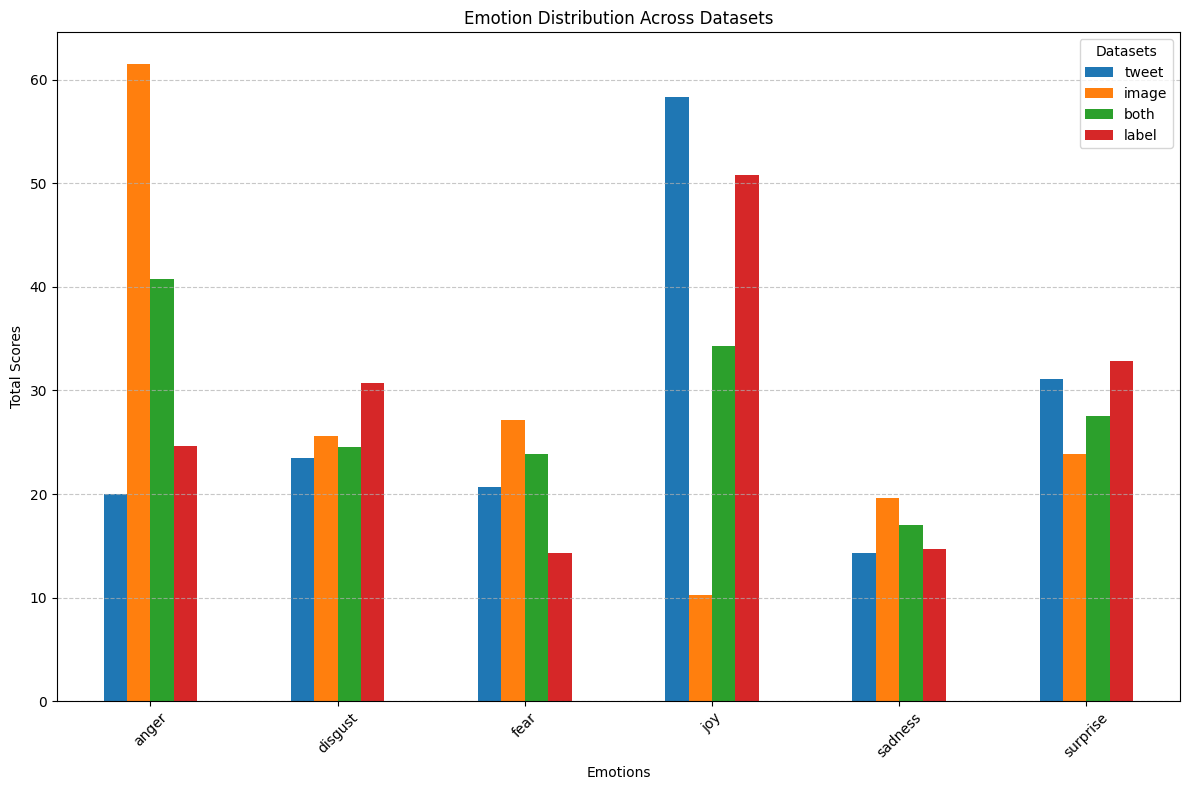

In [22]:

combined_totals = pd.DataFrame({
    'tweet': tweet_totals,
    'image': clip_totals,
    'both': clip_tweet_totals,
    'label': reply_totals,
})

# Plotting the data
plt.figure(figsize=(8, 8))
combined_totals.plot(kind='bar', figsize=(12, 8))
plt.title("Emotion Distribution Across Datasets")
plt.xlabel("Emotions")
plt.ylabel("Total Scores")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Datasets")
plt.tight_layout()
plt.show()

In [23]:
filtered_df = tweets_df[
    tweets_df["clip_distribution"].apply(lambda x: max(x, key=x.get) == "anger") &
    tweets_df["tweet_distribution"].apply(lambda x: max(x, key=x.get) == "joy")
]

filtered_df['abs_diff'] = filtered_df.apply(lambda row: row['clip_distribution']['anger'] + row['tweet_distribution']['joy'], axis=1)

sorted_df = filtered_df.sort_values(by='abs_diff', ascending=False)
sorted_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_496689/1050350475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['abs_diff'] = filtered_df.apply(lambda row: row['clip_distribution']['anger'] + row['tweet_distribution']['joy'], axis=1)


1100723112314843136
Tweet 1: #butterfly #smalltortoiseshell beautiful - but it’s a bit early mate! #climatechange #GlobalWarming [URL]
Tweet Distribution: {'fear': 0.02914309, 'disgust': 0.01307049, 'joy': 0.86895257, 'surprise': 0.05505749, 'sadness': 0.02610704, 'anger': 0.00766932}
CLIP Distribution: {'fear': 0.032711677, 'disgust': 0.12930873, 'joy': 0.0053000045, 'surprise': 0.041601103, 'sadness': 0.024338923, 'anger': 0.7667396}
reply Distribution: {'fear': 0.0277952, 'disgust': 0.005279, 'joy': 0.4771594, 'surprise': 0.054186, 'sadness': 0.4334062, 'anger': 0.0021742}
--------------------------------------------------
1098851263553437696
Tweet 2: Girls are also leading on mitigating #ClimateChange Join the #girls movement #Recycling girl #GreenKidsAwards ceremony. Our 🌏 our business #MyLittleHandsBigImpact #environment [URL]
Tweet Distribution: {'fear': 0.01072476, 'disgust': 0.00322281, 'joy': 0.84276676, 'surprise': 0.13417914, 'sadness': 0.00756696, 'anger': 0.00153957}
CLIP

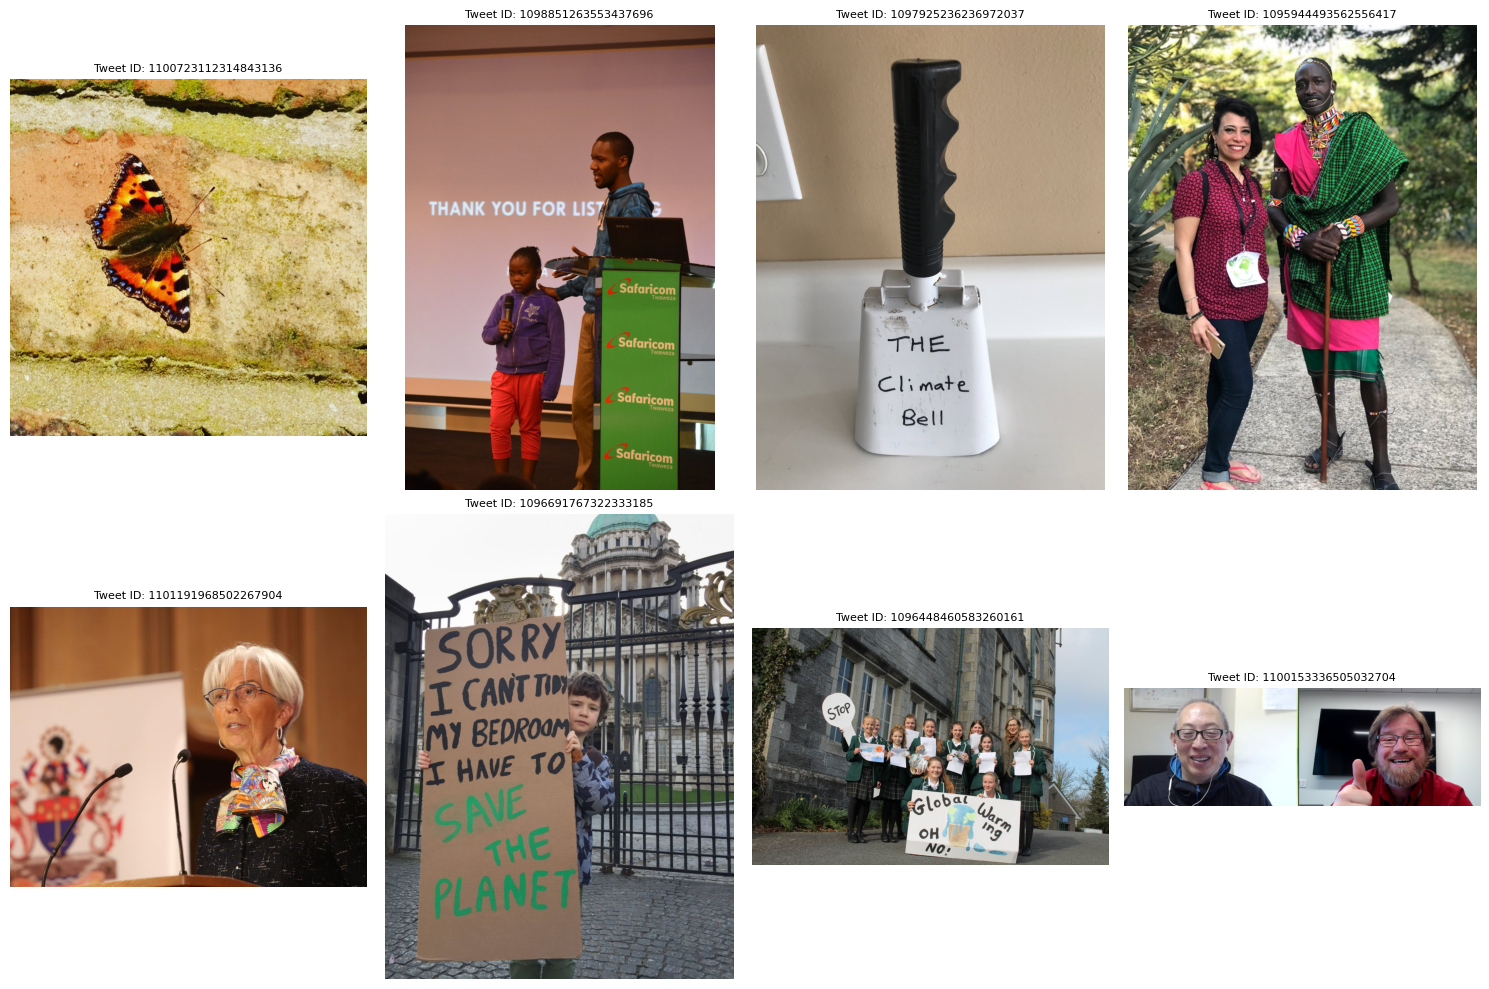

In [24]:
visualize_tweets(sorted_df, start_idx=0, end_idx=8)

In [26]:
# with high divergence between replies and clip
high_jsd_images = tweets_df.sort_values(by='jsd_image_reply', ascending=False)
high_jsd_images.reset_index(drop=True, inplace=True)

In [27]:
high_jsd_images.head(3)

conversation_id                                         tweet_text  \
0  1098328529836609542  Today on #WorldSocialJusticeDay, we remember t...   
1  1096425329923686400  #FollowFriday It's vital that you FOLLOW & RET...   
2  1099475997613801472  What an experience. Such a pleasure walking fo...   

                           roberta-large-predictions  \
0  [('optimism', 0.966646671295166), ('fear', 0.5...   
1  [('optimism', 0.9724814891815186), ('joy', 0.9...   
2  [('optimism', 0.9873092770576477), ('joy', 0.9...   

                                  mapped_predictions  \
0  [('fear', 0.20399290010019408), ('disgust', 0....   
1  [('fear', 0.00608904912179503), ('disgust', 0....   
2  [('fear', 0.012302816531070637), ('disgust', 0...   

                                averaged_predictions  \
0  [('fear', 0.004096314631106435), ('disgust', 0...   
1  [('fear', 0.006845977230008462), ('disgust', 0...   
2  [('fear', 0.006642161813864548), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.852188   
1                         0.994247   
2                         0.999965   

                                    clip_predictions  \
0  [('anger', 0.6510068), ('sadness', 0.1415521),...   
1  [('anger', 0.4834549), ('disgust', 0.28529906)...   
2  [('anger', 0.36426672), ('disgust', 0.3270926)...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.023795                      0.201525   
1                        0.025761                      0.039009   
2                        0.033232                      0.039707   

                        matched_filename  ...  \
0  id_1098328529836609542_2019-02-20.jpg  ...   
1  id_1096425329923686400_2019-02-15.jpg  ...   
2  id_1099475997613801472_2019-02-24.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.6510068, 'sadness': 0.1415521, 'di...   
1  {'anger': 0.4834549, 'disgust': 0.28529906, 's...   
2  {'anger': 0.36426672, 'disgust': 0.3270926, 'f...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.1300255, 'disgust': 0.05615, 'joy':...  0.495589  0.696823   
1  {'fear': 0.0469307, 'disgust': 0.1452068, 'joy...  0.160082  0.901086   
2  {'fear': 0.1182399, 'disgust': 0.1659694, 'joy...  0.041986  0.900447   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.683899         0.928180       2.137664       0.501462       2.372764   
1   0.516254         0.925663       0.684105       0.371085       2.096334   
2   0.509617         0.918140       0.721891       0.627429       2.134958   

   cosine_similarity_multi  
0                 0.494778  
1                 0.828427  
2                 0.850995  

[3 rows x 22 columns]

1098851263553437696
Tweet 1: Girls are also leading on mitigating #ClimateChange Join the #girls movement #Recycling girl #GreenKidsAwards ceremony. Our 🌏 our business #MyLittleHandsBigImpact #environment [URL]
Tweet Distribution: {'fear': 0.01072476, 'disgust': 0.00322281, 'joy': 0.84276676, 'surprise': 0.13417914, 'sadness': 0.00756696, 'anger': 0.00153957}
CLIP Distribution: {'fear': 0.08244331, 'disgust': 0.09047955, 'joy': 0.010988973, 'surprise': 0.09584811, 'sadness': 0.056689434, 'anger': 0.66355056}
reply Distribution: {'fear': 0.0071747, 'disgust': 0.0021503, 'joy': 0.7442691, 'surprise': 0.2413507, 'sadness': 0.0028449, 'anger': 0.0022103}
--------------------------------------------------
1100153336505032704
Tweet 2: A great video chat meeting here on #MotivationMonday with [USER] of [USER] as we talked about the value of social media connectedness for #teachers working on issues like #climatechange and #evolution! Thanks for your time Paul! #SupportScience #SupportEachOthe

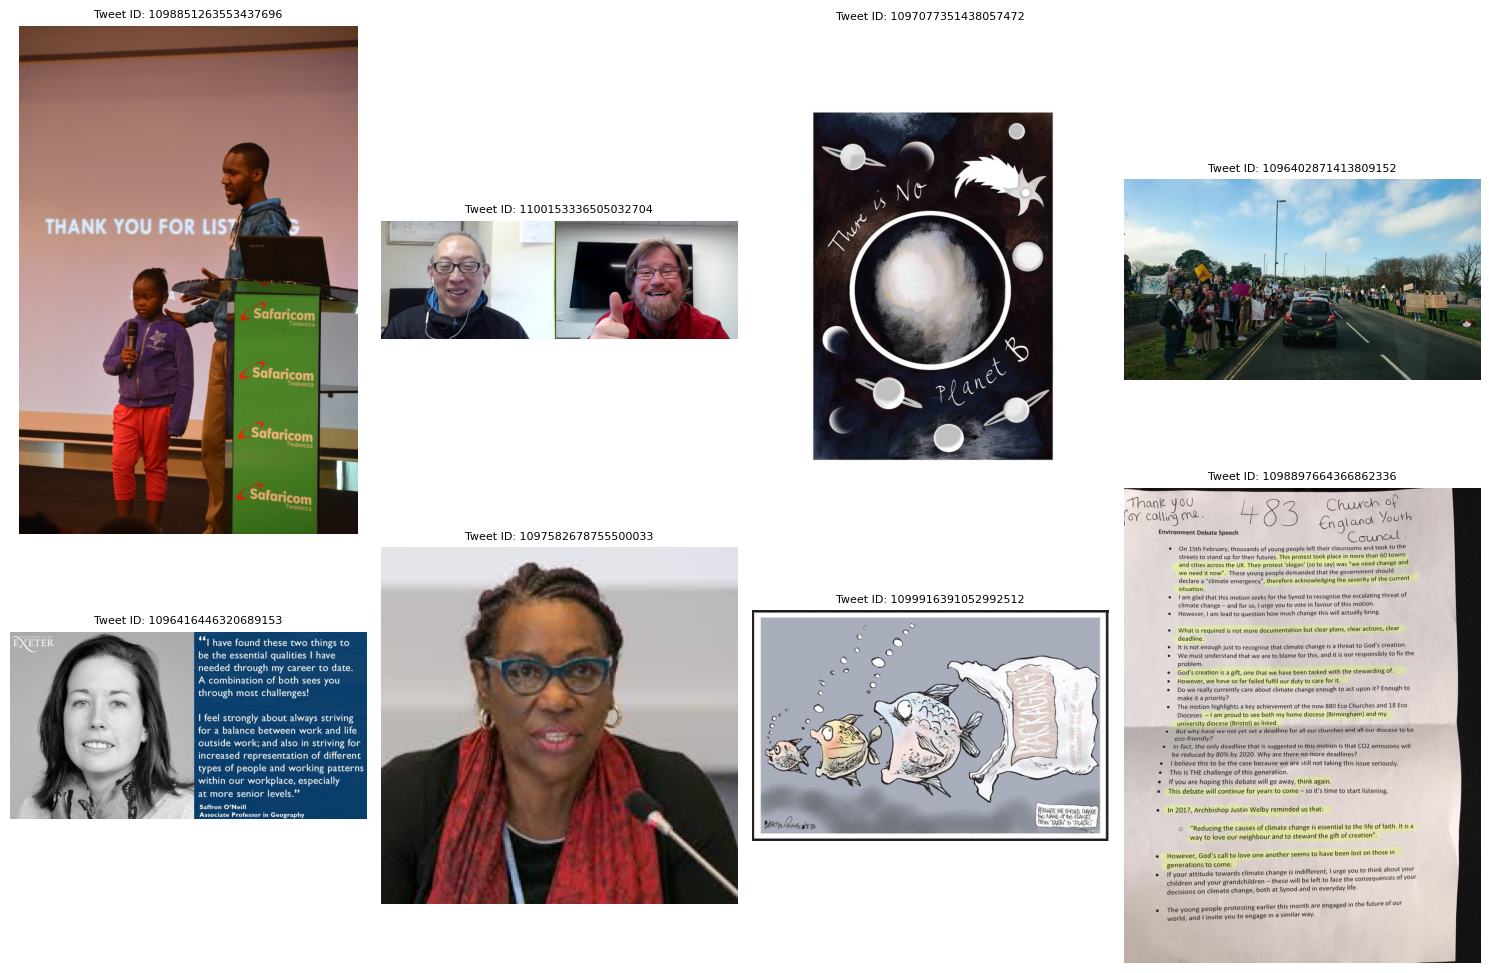

In [31]:
visualize_tweets(high_jsd_images, start_idx=8, end_idx=16)

In [29]:
low_jsd_images = tweets_df.sort_values(by='jsd_image_reply')
low_jsd_images.reset_index(drop=True, inplace=True)

1096893166693900294
Tweet 1: Climate change, the existential threat:  44%, second from bottom.Humanity's own ignorance, driven by a blanket fossil fuel industry funded dis- & mis-information campaign, is going to be our undoing. [URL]
Tweet Distribution: {'fear': 0.38120062, 'disgust': 0.24799703, 'joy': 0.01036901, 'surprise': 0.0173059, 'sadness': 0.1185653, 'anger': 0.22456214}
CLIP Distribution: {'fear': 0.16039239, 'disgust': 0.47346637, 'joy': 0.0035356036, 'surprise': 0.09172613, 'sadness': 0.025972892, 'anger': 0.24490668}
reply Distribution: {'fear': 0.2091212, 'disgust': 0.3893383, 'joy': 0.0205891, 'surprise': 0.0504273, 'sadness': 0.0245779, 'anger': 0.3059463}
--------------------------------------------------
1100417469620072448
Tweet 2: Looks like Molly is perfectly happy with the climate change situation. #happycat [URL]
Tweet Distribution: {'fear': 0.00470474, 'disgust': 0.00696368, 'joy': 0.956942, 'surprise': 0.01782563, 'sadness': 0.00833427, 'anger': 0.00522968}
CL

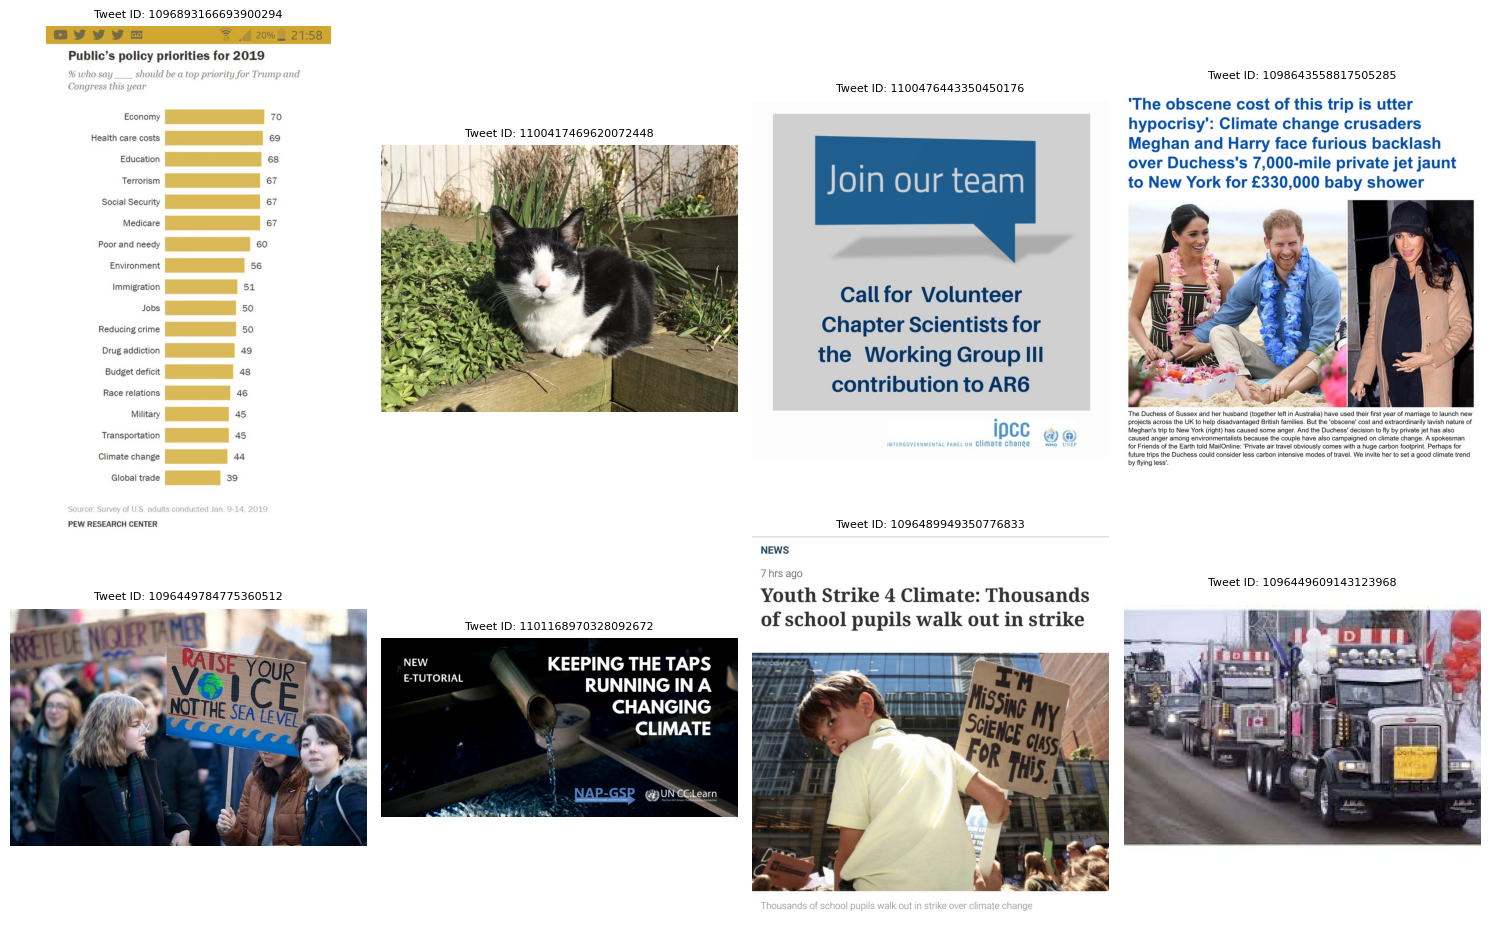

In [30]:
visualize_tweets(low_jsd_images, start_idx=0, end_idx=8)

In [46]:
# with high divergence between replies and combined clip and text
high_jsd_combined = tweets_df.sort_values(by='jsd_multi', ascending=False)
high_jsd_combined.reset_index(drop=True, inplace=True)

In [47]:
high_jsd_combined.head(3)

conversation_id                                         tweet_text  \
0  1096508220921835525  Thousands of UK students skip school for clima...   
1  1100699069037625344  Why are big businesses (like Shell and BP) sti...   
2  1097486758265188352  #NowReading | Worldwide, 20.8 million tons of ...   

                           roberta-large-predictions  \
0  [('sadness', 0.9059814214706421), ('disgust', ...   
1  [('anger', 0.9166171550750732), ('disgust', 0....   
2  [('sadness', 0.893392026424408), ('fear', 0.85...   

                                  mapped_predictions  \
0  [('fear', 0.28478632670826576), ('disgust', 0....   
1  [('fear', 0.019803260987205445), ('disgust', 0...   
2  [('fear', 0.42692690867730654), ('disgust', 0....   

                                averaged_predictions  \
0  [('fear', 0.004097973576324537), ('disgust', 0...   
1  [('fear', 0.004421200694411544), ('disgust', 0...   
2  [('fear', 0.006388390008331149), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.021592   
1                         0.060846   
2                         0.090228   

                                    clip_predictions  \
0  [('fear', 0.43530864), ('anger', 0.2611676), (...   
1  [('disgust', 0.41582605), ('anger', 0.3924651)...   
2  [('anger', 0.8127797), ('surprise', 0.06904385...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.064699                      0.795165   
1                        0.036512                      0.975574   
2                        0.025264                      0.123060   

                        matched_filename  ...  \
0  id_1096508220921835525_2019-02-15.jpg  ...   
1  id_1100699069037625344_2019-02-27.jpg  ...   
2  id_1097486758265188352_2019-02-18.jpg  ...   

                                   clip_distribution  \
0  {'fear': 0.43530864, 'anger': 0.2611676, 'disg...   
1  {'disgust': 0.41582605, 'anger': 0.3924651, 'f...   
2  {'anger': 0.8127797, 'surprise': 0.06904385, '...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.3600474833541329, 'disgust': 0.1965...  0.939652  0.446768   
1  {'fear': 0.06413614049360272, 'disgust': 0.403...  0.878562  0.632307   
2  {'fear': 0.23105644333865327, 'disgust': 0.067...  0.866535  0.432019   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.915209         0.746285       2.129236       0.410273       2.209578   
1   0.890761         0.786799       1.870696       0.860681       1.880442   
2   0.886685         0.861399       1.921801       0.772624       2.105776   

   cosine_similarity_multi  
0                 0.046472  
1                 0.048838  
2                 0.068549  

[3 rows x 22 columns]

In [28]:
tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]

conversation_id                                         tweet_text  \
394   1096398745745408000  “There can be no sustainable econ growth w/o w...   
1656  1101068465039949824  4/4 [USER]: \The new, safer nuclear reactors t...   

                              roberta-large-predictions  \
394   [('optimism', 0.9866390228271484), ('anticipat...   
1656  [('anticipation', 0.9034678936004639), ('optim...   

                                     mapped_predictions  \
394   [('fear', 0.018522344818810377), ('disgust', 0...   
1656  [('fear', 0.02539539411730543), ('disgust', 0....   

                                   averaged_predictions  \
394   [('fear', 0.2996671284860745), ('disgust', 0.2...   
1656  [('fear', 0.39704822097077075), ('disgust', 0....   

      cosine_similarity_tweet_replies  \
394                          0.166844   
1656                         0.252243   

                                       clip_predictions  \
394   [('surprise', 0.25219026), ('anger', 0.2123019...   
1656  [('anger', 0.4915793), ('disgust', 0.17426959)...   

      cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
394                         0.758185                      0.365405   
1656                        0.670733                      0.164711   

                           matched_filename  ...  \
394   id_1096398745745408000_2019-02-15.jpg  ...   
1656  id_1101068465039949824_2019-02-28.jpg  ...   

                                      clip_distribution  \
394   {'surprise': 0.25219026, 'anger': 0.21230192, ...   
1656  {'anger': 0.4915793, 'disgust': 0.17426959, 'f...   

                                        clip_tweet_dist       jsd jsd_image  \
394   {'fear': 0.06906215490940519, 'disgust': 0.101...  0.814400  0.605127   
1656  {'fear': 0.07969250705865272, 'disgust': 0.091...  0.753114  0.688208   

      jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
394    0.528802         0.288076       1.086886       2.288316       2.261335   
1656   0.468709         0.292057       1.259757       2.125241       2.308428   

      cosine_similarity_multi  
394                  0.454280  
1656                 0.571961  

[2 rows x 22 columns]

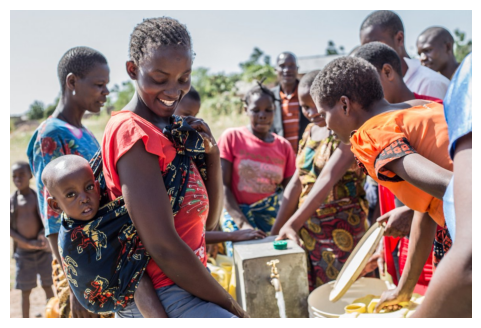

“There can be no sustainable econ growth w/o women’s empowerment, and there can be no women’s #empowerment w/o access to comprehensive #reproductivehealth services, including #familyplanning” – [USER] [URL] #Africa #Tanzania #InterestingReads #ChoiceQuotes [URL]
{'fear': 0.018522344818810377, 'disgust': 0.008249982463429, 'joy': 0.719094994940242, 'surprise': 0.24263078322005346, 'sadness': 0.006730773222672264, 'anger': 0.004771121334792866}
{'surprise': 0.25219026, 'anger': 0.21230192, 'disgust': 0.19461864, 'sadness': 0.14719376, 'fear': 0.119601965, 'joy': 0.0740934}
{'fear': 0.2996671284860745, 'disgust': 0.21790947263908647, 'joy': 0.059766776786421665, 'surprise': 0.03154243090649841, 'sadness': 0.26149301062093444, 'anger': 0.1296211805609845}


In [29]:
path = "/work/ptyagi/ClimateVisions/Images/2019/02_February/id_1096398745745408000_2019-02-15.jpg"
image = Image.open(path)

# Set the figure size
plt.figure(figsize=(6, 4)) 
plt.imshow(image)
plt.axis('off')  # Remove axes for better visualization
plt.show()
print(tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]['tweet_text'].iloc[0])
print(tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]['tweet_distribution'].iloc[0])
print(tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]['clip_distribution'].iloc[0])
print(tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]['average_reply_distribution'].iloc[0])

In [30]:
high_jsd_replies = divergence_df[divergence_df['mean_jsd'] > 0.7] # high divergennce intra replies

In [31]:
high_jsd_replies_df = replies_df[replies_df['conversation_id'].isin(high_jsd_replies['conversation_id'])]
high_jsd_replies_df.reset_index(drop=True, inplace=True)

In [34]:
high_jsd_replies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         140 non-null    int64  
 1   conversation_id            140 non-null    int64  
 2   created_at                 140 non-null    object 
 3   replies                    140 non-null    object 
 4   tweet_text                 140 non-null    object 
 5   tweet_lang                 140 non-null    object 
 6   lang_confidence            140 non-null    float64
 7   roberta-large-predictions  140 non-null    object 
 8   mapped_predictions         140 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 10.0+ KB


In [35]:
high_jsd_replies_df.head()

id      conversation_id                 created_at  \
0  1095930646671835136  1095926032505425921  2019-02-14 06:20:02+00:00   
1  1095941393745354752  1095940937698721793  2019-02-14 07:02:44+00:00   
2  1095941526423851008  1095940937698721793  2019-02-14 07:03:16+00:00   
3  1095975015768576000  1095926032505425921  2019-02-14 09:16:20+00:00   
4  1096391526433865729  1096390095341522944  2019-02-15 12:51:24+00:00   

                                             replies  \
0                                        Nailed it!!   
1                                          thank you   
2                                              Arson   
3                                    ok warhawk.....   
4  by the looks of itnot prepared for the amount ...   

                                          tweet_text tweet_lang  \
0       WEATHER UPDATESource: AccuWeather[URL] [URL]         en   
1  Landscape-associated differences in fine-scale...         en   
2  Landscape-associated differences in fine-scale...         en   
3       WEATHER UPDATESource: AccuWeather[URL] [URL]         en   
4  School pupil climate change protest today in #...         en   

   lang_confidence                          roberta-large-predictions  \
0         0.458873  [('joy', 0.957831859588623), ('optimism', 0.84...   
1         0.749205  [('joy', 0.9701732397079468), ('optimism', 0.7...   
2         0.749205  [('anger', 0.913879930973053), ('disgust', 0.5...   
3         0.458873  [('anticipation', 0.19786803424358368), ('ange...   
4         0.705542  [('anger', 0.9417855143547058), ('disgust', 0....   

                                  mapped_predictions  
0  [('fear', 0.016461996224881197), ('joy', 0.791...  
1  [('fear', 0.006845977231109438), ('joy', 0.951...  
2  [('fear', 0.1093412396137885), ('joy', 0.00763...  
3  [('fear', 0.08678651528064131), ('joy', 0.0628...  
4  [('fear', 0.04224794163581299), ('joy', 0.0103...

In [76]:
def plot_heatmap(jsd_values, reply_ids):
    heatmap_data = np.zeros((len(reply_ids), len(reply_ids)))
    idx = 0
    for i in range(len(reply_ids)):
        for j in range(i + 1, len(reply_ids)):
            heatmap_data[i, j] = jsd_values[idx]
            heatmap_data[j, i] = jsd_values[idx]
            idx += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, xticklabels=reply_ids, yticklabels=reply_ids, annot=True, cmap="coolwarm", cbar=True)
    plt.title("Pairwise JSD Heatmap for Replies")
    plt.xlabel("Replies")
    plt.ylabel("Replies")
    plt.show()


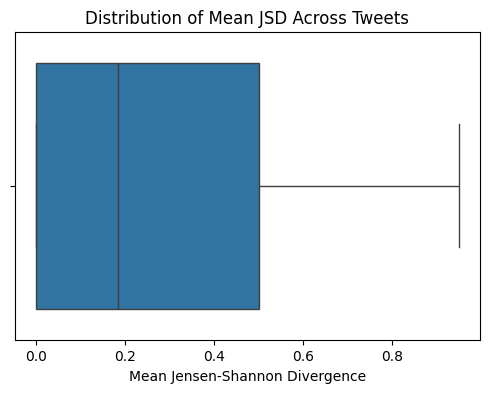

In [77]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=divergence_df, x='mean_jsd')
plt.title("Distribution of Mean JSD Across Tweets")
plt.xlabel("Mean Jensen-Shannon Divergence")
plt.show()


In [86]:
low_jsd_images = tweets_df[tweets_df['jsd_image'] < 0.3]

In [87]:
low_jsd_images.reset_index(drop=True, inplace=True)

1097805912125902848
Tweet 1: At the start of Planetary Security Conference, [USER] shares his experience on how #ClimateChange and environmental damage fueled and resulted in conlicts in Bangladesh, Sudan and Iraq, before Dutch MFA minister   [USER] takes the floor #PSC19 [URL]
Tweet Distribution: {'fear': 0.2981726891237035, 'disgust': 0.10033476297844976, 'joy': 0.07752321326675204, 'surprise': 0.2191560529504403, 'sadness': 0.26431868384954665, 'anger': 0.04049459783110775}
CLIP Distribution: {'anger': 0.35699558, 'disgust': 0.26662388, 'surprise': 0.15496203, 'joy': 0.09638095, 'sadness': 0.09135859, 'fear': 0.033678923}
--------------------------------------------------
1097910354628280320
Tweet 2: Ending #ViolenceAgainstWomen and #Girls is NOT an isolated issue it interlinks with every facet of society#VAWG⛓️#SustainableDevelopment⛓️#Mental & #PhysicalHealth⛓️#Crime ⛓️#ClimateChange⛓️#EconomicSustainability⛓️#SocialandCultural #Norms⛓️#PopulationGrowth⛓️#HumanTrafficking [URL]
Tw

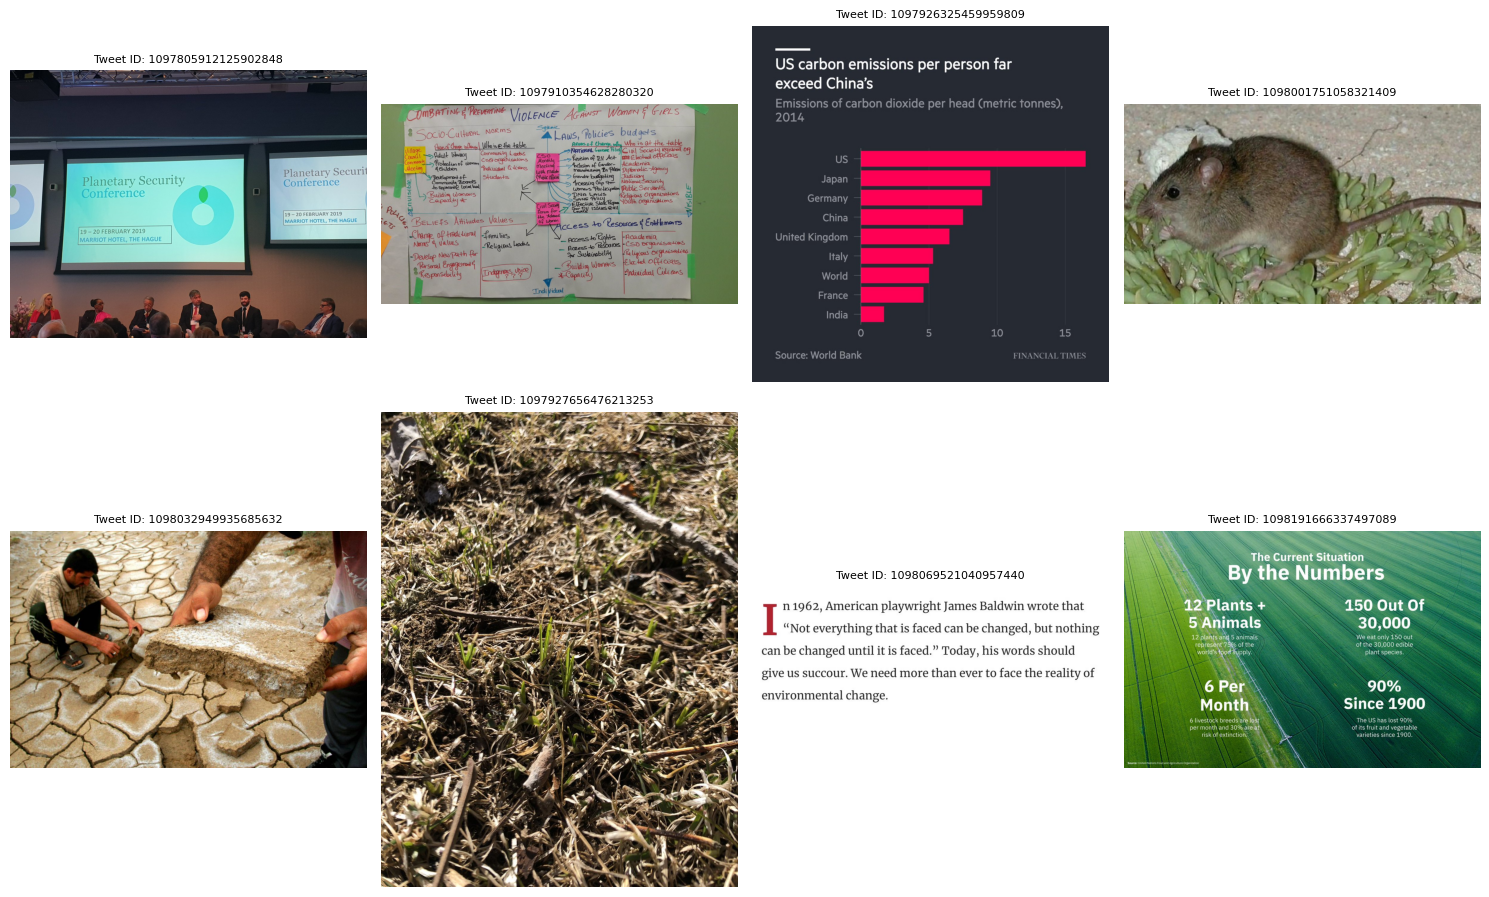

In [89]:
visualize_tweets(low_jsd_images, start_idx=16, end_idx=24)

# High JSD between labels and averge of clip and roberta

In [58]:
high_jsd_mutli = tweets_df[tweets_df['jsd_multi'] > 0.7]

In [59]:
high_jsd_mutli.reset_index(drop=True, inplace=True)


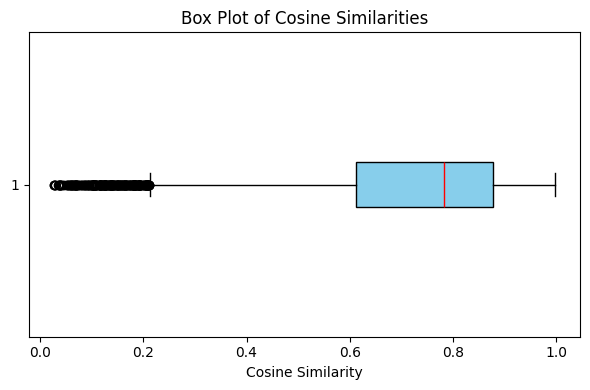

In [64]:
plt.figure(figsize=(6, 4))
plt.boxplot(tweets_df['cosine_similarity_multi'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.tight_layout()
plt.show()

In [65]:
train_data, temp_data = train_test_split(tweets_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

In [66]:
test_data['cosine_similarity_multi'].mean()

0.709041413816695

In [67]:
test_data["cosine_similarity_tweet_replies"].mean()

0.6919531516105084

In [68]:
test_data["cosine_similarity_clip_replies"].mean()

0.5017263212570278

In [72]:
high_jsd_replies_df

id      conversation_id                 created_at  \
278    1156847619412516865  1156845060081815552  2019-08-01 08:42:20+00:00   
281    1156848513805950976  1156845060081815552  2019-08-01 08:45:53+00:00   
297    1156853299691294720  1156852677080489984  2019-08-01 09:04:54+00:00   
313    1156856609701859328  1156852677080489984  2019-08-01 09:18:03+00:00   
591    1156928149927714816  1156922246008623104  2019-08-01 14:02:20+00:00   
...                    ...                  ...                        ...   
50889  1167857824426123264  1167855361111580673  2019-08-31 17:52:57+00:00   
50934  1167871656162807808  1167866241211486209  2019-08-31 18:47:55+00:00   
50959  1167879291394117633  1167866241211486209  2019-08-31 19:18:15+00:00   
50964  1167880550939389952  1167877914869690369  2019-08-31 19:23:16+00:00   
51046  1167905413875978240  1167877914869690369  2019-08-31 21:02:03+00:00   

                                                 replies  \
278                            Dede is a dream come true   
281    is this the same honorable person that yesterd...   
297    why is it that we got a nice bit of weather an...   
313    oh we will not but increasing sunshine is an i...   
591                               i use public transport   
...                                                  ...   
50889  they were not listening then and they are stil...   
50934           But has anyone asked you for an opinion?   
50959  thank you it was a great honour to sit and tal...   
50964  stick to the good work for charity prefer you ...   
51046  we did one of those last week but did not real...   

                                              tweet_text tweet_lang  \
278    Minister of Lands, Agriculture, Water,Climate ...         en   
281    Minister of Lands, Agriculture, Water,Climate ...         en   
297    UK #climatechange indicator 2018: 2018 was the...         en   
313    UK #climatechange indicator 2018: 2018 was the...         en   
591    It's now widely known #climatechange is the en...         en   
...                                                  ...        ...   
50889  Worth Another Look: 15 December 2015 UK MP Dav...         en   
50934  As the [USER] Secretary-General has noted,  wh...         en   
50959  As the [USER] Secretary-General has noted,  wh...         en   
50964  We were blessed with perfect Lake District wea...         en   
51046  We were blessed with perfect Lake District wea...         en   

       lang_confidence                          roberta-large-predictions  \
278           0.854413  [('joy', 0.993438184261322), ('optimism', 0.94...   
281           0.854413  [('anger', 0.8467773795127869), ('disgust', 0....   
297           0.795930  [('anger', 0.9557802677154541), ('disgust', 0....   
313           0.795930  [('optimism', 0.6479735374450684), ('anticipat...   
591           0.886806  [('sadness', 0.3003625273704529), ('disgust', ...   
...                ...                                                ...   
50889         0.668545  [('anger', 0.9648580551147461), ('disgust', 0....   
50934         0.888822  [('anticipation', 0.6487682461738586), ('sadne...   
50959         0.888822  [('joy', 0.9937946796417236), ('optimism', 0.9...   
50964         0.913983  [('optimism', 0.9680694341659546), ('joy', 0.9...   
51046         0.913983  [('fear', 0.9156543612480164), ('anticipation'...   

                                      mapped_predictions  
278    [('anger', 0.0020995781886712314), ('fear', 0....  
281    [('anger', 0.40751311635870957), ('fear', 0.01...  
297    [('anger', 0.31071780786018627), ('fear', 0.05...  
313    [('anger', 0.011548423393626045), ('fear', 0.0...  
591    [('anger', 0.07775364275222364), ('fear', 0.09...  
...                                                  ...  
50889  [('anger', 0.37458533103598635), ('fear', 0.06...  
50934  [('anger', 0.10394969983179918), ('fear', 0.11...  
50959  [('anger', 0.0020169371840837538), ('fear', 0.... 

In [74]:
filtered_df = high_jsd_replies_df[high_jsd_replies_df['conversation_id'] == 1156845060081815552]

print(filtered_df['tweet_text'].iloc[0])
print(filtered_df[['replies', 'mapped_predictions']].to_string(index=False))

Minister of Lands, Agriculture, Water,Climate and Rural Resettlement  Hon P. Shiri is attending a Green Climate Training Ceremony at Rainbow Towers,Harare.  Green Climate Finance Training is an intiative by private funders and Governments to fight the menace of climate change. [URL]
                                                                                         replies                                                                                                                                                                                        mapped_predictions
                                                                       Dede is a dream come true [('anger', 0.0020995781886712314), ('fear', 0.004812019753507222), ('surprise', 0.053412498880955596), ('disgust', 0.002211924590267632), ('sadness', 0.001636669135592898), ('joy', 0.9358273094510055)]
is this the same honorable person that yesterday called people in parliament monkeys and baboons   [('anger', 0.407513

In [1]:
import os

# Define the paths to the two directories
dir1 = "/work/ptyagi/masterthesis/src/runs/august_exp"
dir2 = "/work/ptyagi/masterthesis/src/runs/february_exp"

# Get filenames in each directory
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find files that are unique to each directory
unique_to_dir1 = sorted(files_dir1 - files_dir2)
unique_to_dir2 = sorted(files_dir2 - files_dir1)

# Display the results
print("Files unique to Directory 1:")
for file in unique_to_dir1:
    print(file)


Files unique to Directory 1:
exp_adamw_only_vit_lr5e-06_drop0.3_epochs2_seed42
exp_adamw_only_vit_lr5e-06_drop0.3_epochs2_seed42_frozen
exp_adamw_only_vit_lr5e-06_drop0.3_epochs5_seed42
exp_adamw_only_vit_lr5e-06_drop0.3_epochs5_seed42_frozen
exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_epochs2_seed7
exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_epochs5_seed7
exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_epochs5_seed7_both_frozen
exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_epochs5_seed7_frozen_clip
exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_epochs5_seed7_frozen_roberta
exp_adamw_roberta_large_lr1e-05_drop0.5_bigger_mlp_epochs5_seed42
exp_adamw_roberta_large_lr1e-05_drop0.5_bigger_mlp_epochs5_seed42_both_frozen
exp_adamw_roberta_large_lr1e-05_drop0.5_bigger_mlp_epochs5_seed42_frozen_clip
exp_adamw_roberta_large_lr1e-05_drop0.5_bigger_mlp_epochs5_seed42_frozen_roberta
exp_adamw_roberta_large_lr1e-05_drop0.5_gelu_epochs2_seed7
exp_adamw_roberta_large_lr1e-05_drop0.5_gelu_epochs2_seed7_fr

In [2]:
print("\nFiles unique to Directory 2:")
for file in unique_to_dir2:
    print(file)


Files unique to Directory 2:
